## 1. Data exploration and cleaning

In the first part of this project I started with data exploration and cleaning of data, visualizing basic descriptive statistics and making some considerations.

In [2]:
# Standard libraries for data manipulation and visualization
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt

# File system operations
import os

# Geoprocessing
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from scipy.spatial import cKDTree
from scipy.interpolate import Rbf

# API and download
import requests
from requests_oauthlib import OAuth2Session
import boto3
from botocore.client import Config


In [3]:
# Visualize the geopackage
resa_girasole = gpd.read_file("resa_girasole_2022.gpkg")
resa_girasole.head()  

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1333142.195 5597662.213)


In [4]:
# Basic info, we can see that UMIDITA have some missing values
resa_girasole.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Data/Ora    1962 non-null   object  
 1   Longitudin  1962 non-null   object  
 2   Latitudine  1962 non-null   object  
 3   RESAKG      1962 non-null   float64 
 4   VELOCITA    1962 non-null   float64 
 5   AREA        1962 non-null   float64 
 6   UMIDITA     1925 non-null   float64 
 7   geometry    1962 non-null   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 122.8+ KB


In [5]:
# Visualization of basic descriptive statistics
resa_girasole.describe()

,RESAKG,VELOCITA,AREA,UMIDITA
count,1962.000000,1962.000000,1962.000000,1925.000000
mean,2255.285423,4.903976,143.032629,27.022805
std,699.827651,0.614924,17.935293,6.154021
min,50.000000,0.780000,22.750000,18.600000
25%,1792.500000,4.570000,133.292000,22.200000
50%,2300.000000,4.900000,142.917000,25.800000
75%,2730.000000,5.180000,151.083000,30.200000
max,4880.000000,10.910000,318.208000,50.100000


Some variables show extreme minimum and maximum values (e.g. RESAKG with a minimum of 50 and a maximum of 4880), which could indicate the presence of outliers or simple a wide distribution. 

In [6]:
# How much missing values for UMIDITA
resa_girasole["UMIDITA"].isna().sum()

37

In [7]:
# Remove duplicates if they exist
resa_girasole = resa_girasole.drop_duplicates(subset=['Longitudin', 'Latitudine'])

In [8]:
# We can see that there weren't any duplicates
resa_girasole.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Data/Ora    1962 non-null   object  
 1   Longitudin  1962 non-null   object  
 2   Latitudine  1962 non-null   object  
 3   RESAKG      1962 non-null   float64 
 4   VELOCITA    1962 non-null   float64 
 5   AREA        1962 non-null   float64 
 6   UMIDITA     1925 non-null   float64 
 7   geometry    1962 non-null   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 122.8+ KB


### Handling missing values

For missing values we can use a lot of different methods, for exaple filling them with the median or mean value. In this case I decided to fill them with a spatial interpolation method that assigns a value respect the value of UMIDITA present in other points, using Rbf (Radial Basis Function).

In [9]:
# Load the GeoDataFrame
resa_girasole = gpd.read_file("resa_girasole_2022.gpkg")

# Convert Longitudin and Latitudine to numeric
resa_girasole['Longitudin'] = resa_girasole['Longitudin'].str.replace(',', '.').astype(float)
resa_girasole['Latitudine'] = resa_girasole['Latitudine'].str.replace(',', '.').astype(float)

# Separate data with and without UMIDITA
data_with_umidita = resa_girasole.dropna(subset=['UMIDITA'])
data_without_umidita = resa_girasole[pd.isnull(resa_girasole['UMIDITA'])]

# Extract coordinates and UMIDITA values
x_known = data_with_umidita['Longitudin'].values
y_known = data_with_umidita['Latitudine'].values
z_known = data_with_umidita['UMIDITA'].values

x_unknown = data_without_umidita['Longitudin'].values
y_unknown = data_without_umidita['Latitudine'].values

# Perform spatial interpolation using Rbf (Radial Basis Function)
rbf = Rbf(x_known, y_known, z_known, function='linear')
z_unknown = rbf(x_unknown, y_unknown)

# Update the GeoDataFrame with interpolated values
resa_girasole.loc[pd.isnull(resa_girasole['UMIDITA']), 'UMIDITA'] = z_unknown


In [10]:
# We filled the null data and we can see that now there is none
resa_girasole['UMIDITA'].isna().sum()

0

In [11]:
resa_girasole.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09",11.975824,44.847491,1870.0,4.80,140.000,26.689078,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24",11.975816,44.847675,1270.0,4.83,140.875,29.290996,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40",11.975815,44.847879,1420.0,4.78,139.417,28.083621,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55",11.975821,44.848059,2010.0,4.85,141.458,33.100000,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10",11.975820,44.848244,1320.0,4.80,140.000,33.100000,POINT (1333142.195 5597662.213)


### Outliers
We can check for outliers fo example with the IQR method, and decide if delete or substitute them.

In [12]:
# It is possible to analize if there are too much outliers
col = ['RESAKG','VELOCITA',	'AREA',	'UMIDITA']

# Calculate Q1 and Q3 for each column
Q1 = resa_girasole[col].quantile(0.25)
Q3 = resa_girasole[col].quantile(0.75)

# Calculate IQR for each column
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
outliers = ((resa_girasole[col] < lower_bound) | (resa_girasole[col] > upper_bound))

# Count the number of potential outliers in each column
outlier_counts_before = outliers.sum()

# Display the count of potential outliers for each column
print(outlier_counts_before)

RESAKG      25
VELOCITA    85
AREA        85
UMIDITA     56
dtype: int64


In [13]:
# Selecting the colums for correlation
columns_of_interest = ['RESAKG','VELOCITA',	'AREA',	'UMIDITA']

# Correlation matrix
correlation_matrix = resa_girasole[columns_of_interest].corr()

In [14]:
correlation_matrix.style.background_gradient(cmap='coolwarm')

,RESAKG,VELOCITA,AREA,UMIDITA
RESAKG,1.000000,-0.374292,-0.374292,-0.172297
VELOCITA,-0.374292,1.000000,1.000000,-0.145825
AREA,-0.374292,1.000000,1.000000,-0.145825
UMIDITA,-0.172297,-0.145825,-0.145825,1.000000


In this case I decided to not fill the outliers found because the trend of data seems however be in line with the type of data acquired (agricoltural machinery harvesting), in any case it would be possible to eliminate them if in subsequent analyzes the data were not compliant. 

It is interesting to analyze the correlation 1:1 between VELOCITA and AREA.

### Plotting data

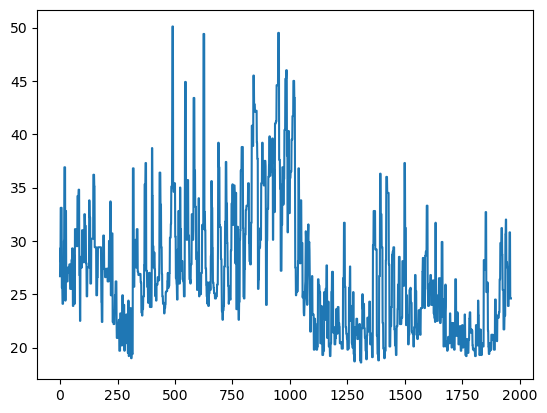

In [15]:
resa_girasole['UMIDITA'].plot()
plt.show()

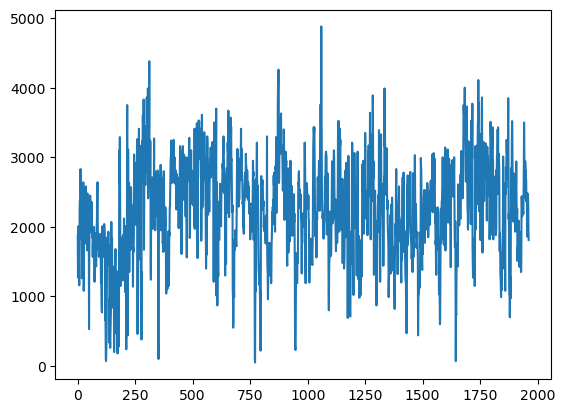

In [160]:
resa_girasole['RESAKG'].plot()
plt.show()

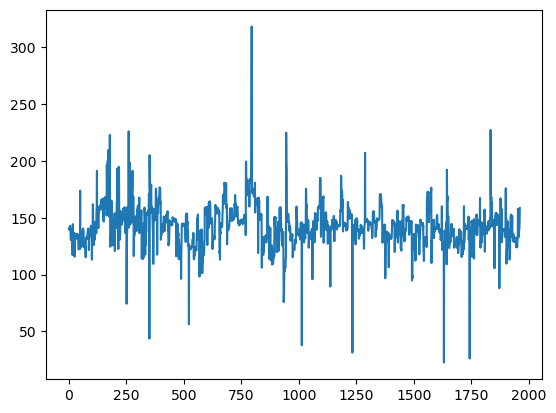

In [161]:
resa_girasole['AREA'].plot()
plt.show()

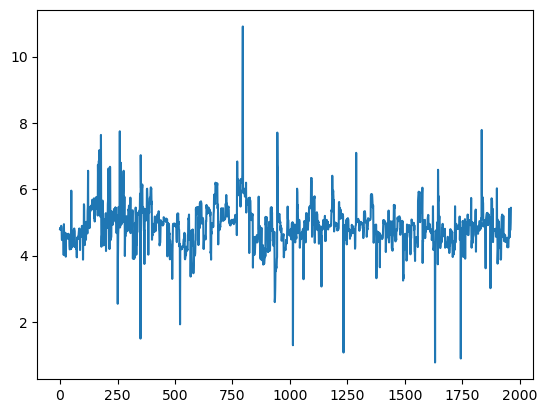

In [162]:
resa_girasole['VELOCITA'].plot()
plt.show()

## 2. Spatial interpolaton of the resulted data

Now we can interpolate the data, for this exercize we are going to generate interpolated rasters for RESAKG and UMIDITY. 

To generate a raster in a specific range and after using it to cut the NDVI image I decided to generate a polygon from the points inside the geopackage.

In [30]:
# Create a convex hull polygon from the points
points = resa_girasole['geometry']
convex_hull_polygon = points.unary_union.convex_hull.buffer(10) #Buffer for extending a little the field

In [17]:
# Save the polygon to a gpkg file
convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs=resa_girasole.crs)
convex_hull_gdf.to_file('Borders.gpkg', driver='GPKG', layer='Borders')

In [16]:
polygon_file = 'Borders.gpkg'

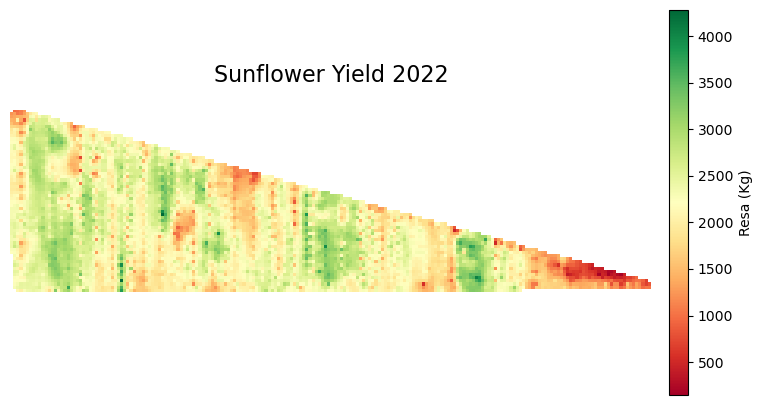

In [207]:
# Now i can define a function for IDW interpolation
def idw_interpolation(geo_df, value_column, grid_x, grid_y, power=2):
    """
    Performs Inverse Distance Weighting (IDW) interpolation

    Args:
        geo_df (geopandas.GeoDataFrame): GeoDataFrame containing the known points
            with their coordinates and values.
        value_column (str): Column name in geo_df containing the values to interpolate
        grid_x (numpy.ndarray): 2D array of X coordinates of the grid points
        grid_y (numpy.ndarray): 2D array of Y coordinates of the grid points
        power (float, optional): Power parameter for the distance weighting. Default is 2

    Returns:
        numpy.ndarray: 2D array of interpolated values corresponding to grid_x and grid_y
    """
    xy = np.vstack((geo_df.geometry.x, geo_df.geometry.y)).T
    z = geo_df[value_column].values
    tree = cKDTree(xy)
    grid_z = np.zeros_like(grid_x)
    
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            distances, idx = tree.query((grid_x[i, j], grid_y[i, j]), k=8)
            weights = 1 / distances**power
            grid_z[i, j] = np.sum(weights * z[idx]) / np.sum(weights)
    
    return grid_z

# Read GeoDataFrame with data
gdf = resa_girasole

# Polygon for the cut
clip_gdf = polygon_file

# Extract bounds from the polygon
bounds = clip_gdf.total_bounds
xmin, ymin, xmax, ymax = bounds

# Vreating a grid for the interpolation
pixel_size = 10  # I set the pixel dimension to 10m (The same of sentinel-2 data)
grid_x, grid_y = np.meshgrid(
    np.arange(xmin, xmax, pixel_size),
    np.arange(ymin, ymax, pixel_size)
)

# Flip y axis for a correct visualization
grid_y = np.flip(grid_y, axis=0)

# Start the interpolation IDW on RESAKG
grid_z = idw_interpolation(gdf, 'RESAKG', grid_x, grid_y)

# Save a temp raster
transform = from_origin(xmin, ymax, pixel_size, pixel_size)
temp_raster_path = 'temp_output_raster.tif'
with rasterio.open(
    temp_raster_path,
    'w',
    driver='GTiff',
    height=grid_z.shape[0],
    width=grid_z.shape[1],
    count=1,
    dtype=grid_z.dtype,
    crs=gdf.crs,
    transform=transform,
) as new_dataset:
    new_dataset.write(grid_z, 1)

# Cut the raster with the polygon
with rasterio.open(temp_raster_path) as src:
    out_image, out_transform = mask(src, clip_gdf.geometry, crop=True, nodata=np.nan)
    out_meta = src.meta.copy()
    # Set zero values as NaN
    out_image[out_image == 0] = np.nan

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": np.nan
})

# Save the raster of interest
output_raster_path = 'Resa_kg.tif'
with rasterio.open(output_raster_path, 'w', **out_meta) as dest:
    dest.write(out_image)

# Remove the temp file
os.remove(temp_raster_path)

# Visualization of interpolated data
plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='RdYlGn')
cbar = plt.colorbar(label='Resa (Kg)', shrink=0.5, pad=0.02)
plt.title('Sunflower Yield 2022', fontsize=16, pad=20)
plt.gca().title.set_position([0.5, 1.05])  # Center title
plt.axis('off')
plt.show()

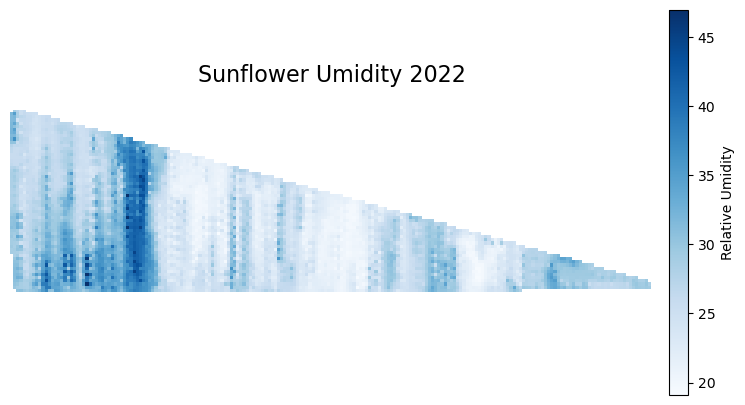

In [208]:
# Same operation for umidity
def idw_interpolation(geo_df, value_column, grid_x, grid_y, power=2):
    """
    Performs Inverse Distance Weighting (IDW) interpolation

    Args:
    geo_df (geopandas.GeoDataFrame): GeoDataFrame containing the known points
        with their coordinates and values.
    value_column (str): Column name in geo_df containing the values to interpolate
    grid_x (numpy.ndarray): 2D array of X coordinates of the grid points
    grid_y (numpy.ndarray): 2D array of Y coordinates of the grid points
    power (float, optional): Power parameter for the distance weighting. Default is 2

    Returns:
    numpy.ndarray: 2D array of interpolated values corresponding to grid_x and grid_y
    """
    xy = np.vstack((geo_df.geometry.x, geo_df.geometry.y)).T
    z = geo_df[value_column].values
    tree = cKDTree(xy)
    grid_z = np.zeros_like(grid_x)
    
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            distances, idx = tree.query((grid_x[i, j], grid_y[i, j]), k=8)
            weights = 1 / distances**power
            grid_z[i, j] = np.sum(weights * z[idx]) / np.sum(weights)
    
    return grid_z

gdf = resa_girasole

clip_gdf = polygon_file

bounds = clip_gdf.total_bounds
xmin, ymin, xmax, ymax = bounds

pixel_size = 10  
grid_x, grid_y = np.meshgrid(
    np.arange(xmin, xmax, pixel_size),
    np.arange(ymin, ymax, pixel_size)
)

grid_y = np.flip(grid_y, axis=0)

grid_z = idw_interpolation(gdf, 'UMIDITA', grid_x, grid_y)

transform = from_origin(xmin, ymax, pixel_size, pixel_size)
temp_raster_path = 'temp_output_raster.tif'
with rasterio.open(
    temp_raster_path,
    'w',
    driver='GTiff',
    height=grid_z.shape[0],
    width=grid_z.shape[1],
    count=1,
    dtype=grid_z.dtype,
    crs=gdf.crs,
    transform=transform,
) as new_dataset:
    new_dataset.write(grid_z, 1)

with rasterio.open(temp_raster_path) as src:
    out_image, out_transform = mask(src, clip_gdf.geometry, crop=True, nodata=np.nan)
    out_meta = src.meta.copy()
    out_image[out_image == 0] = np.nan

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": np.nan
})

output_raster_path = 'Umidity.tif'
with rasterio.open(output_raster_path, 'w', **out_meta) as dest:
    dest.write(out_image)

os.remove(temp_raster_path)

plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='Blues')
cbar = plt.colorbar(label='Relative Umidity', shrink=0.5, pad=0.02)
plt.title('Sunflower Umidity 2022', fontsize=16, pad=20)
plt.gca().title.set_position([0.5, 1.05])
plt.axis('off')
plt.show()

## Download multispectral data for NDVI calculation

It is possible to download directly the data from [Copernicus Browser](https://browser.dataspace.copernicus.eu/?zoom=16&lat=44.84919&lng=11.97401&themeId=DEFAULT-THEME&visualizationUrl=U2FsdGVkX19dKOJr9cjZtvQItXsalTqfD14eF7GDWIQcEU3ViK5ELtuTKLXxrp2D%2BRNvXyNDxZ8LmZq21IIE4rvVT7EYD1zmoEqaAT9L5ivOPI0a0VMBj3oNHBUaJqIm&datasetId=S2_L2A_CDAS&fromTime=2022-08-21T00%3A00%3A00.000Z&toTime=2022-08-21T23%3A59%3A59.999Z&layerId=3_NDVI&demSource3D=%22MAPZEN%22&cloudCoverage=10&dateMode=SINGLE).

For the scope of this project, I proceeded with the Copernicus Data Space Ecosystem Application Programming Interfaces (APIs). I found all the documentation [here](https://documentation.dataspace.copernicus.eu/APIs/Token.html).

Specifically, I downloaded the spectral bands of interest to calculate the NDVI index: RED (B04) and NIR (B08). The code is written to download the data within a specific range, selecting one image per month (the best image with the least cloud cover). I decided to download the images from March to the end of August (the cycle of sowing and harvesting of sunflowers). Of course, it is possible to consider different ranges or methods.


In [18]:
# To select a specific area I need to convert borders in EPSG4326
borders_gdf = gpd.read_file("Borders.gpkg")

# Check the current CRS (optional)
print("Current CRS:", borders_gdf.crs)

# Reproject to EPSG:4326 (WGS 84)
borders_gdf = borders_gdf.to_crs(epsg=4326)

# Check the new CRS (optional)
print("New CRS:", borders_gdf.crs)

# Save the reprojected GeoDataFrame to a new GeoPackage (optional)
borders_gdf.to_file("Borders_EPSG4326.gpkg", driver="GPKG")

Current CRS: EPSG:3857
New CRS: EPSG:4326


In [21]:
Borders = 'Borders_EPSG4326.gpkg'

In [22]:
# Load the GeoPackage
gdf = gpd.read_file(Borders)

# Ensure you have a single polygon (you might need to adjust if you have multiple layers or features)
polygon = gdf.geometry.iloc[0]

# Convert to GeoJSON format
polygon_geojson = polygon.__geo_interface__


First we need the Access Toke to operate:

In [23]:
# OAuth2 session (replace with OAuth2 client details following the instructions on Copernicus site)
client_id = 'client_id'
client_secret = 'client_secret'
token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

# Initialize OAuth2 session
oauth = OAuth2Session(client_id, token=token_url)

# Request access token
token_data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret
}

token_response = requests.post(token_url, data=token_data)

# Check if the request was successful
if token_response.status_code == 200:
    access_token = token_response.json()['access_token']
    print(f"Access Token: {access_token}")

Access Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3MTk1MDg2MDgsImlhdCI6MTcxOTUwODAwOCwianRpIjoiOGZmNDk3OWQtNWI2NS00MTBiLWI1OWUtOGY4ZjkyODExMmYwIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwic3ViIjoiOGVmNjQwM2YtNTNiYS00MzZmLThhMGEtYTA3MTQ1ODMwM2NlIiwidHlwIjoiQmVhcmVyIiwiYXpwIjoic2gtN2E3YmVlNjctZWZlOC00MGMwLWI1NWEtOGQ1OGRhOTE4YTMwIiwic2NvcGUiOiJlbWFpbCBwcm9maWxlIHVzZXItY29udGV4dCIsImNsaWVudEhvc3QiOiI4MS41Ni4xMDcuMTI5IiwiZW1haWxfdmVyaWZpZWQiOmZhbHNlLCJvcmdhbml6YXRpb25zIjpbImRlZmF1bHQtN2NiNDMyNDQtNjAwZC00ZjM0LTk4ODItMWMyOGFkOGFkYzNlIl0sInVzZXJfY29udGV4dF9pZCI6IjE0M2ZkM2JjLWE5YjQtNDIwYS1iM2IzLTIyNWFjOTY1NDg0OSIsImNvbnRleHRfcm9sZXMiOnt9LCJjb250ZXh0X2dyb3VwcyI6WyIvYWNjZXNzX2dyb3Vwcy91c2VyX3R5cG9sb2d5L2NvcGVybmljdXNfZ2VuZXJhbC8iLCIvb3JnYW5pemF0aW9ucy9kZWZhdWx0LTdjYjQzMjQ0LTYwMGQtNGYzNC05ODgyLTFjMjhhZDhhZGMzZS8iXSwicHJlZmVycmVkX3VzZXJuYW1lIjoic2VydmljZS1hY2NvdW50LX

Now I can search and print the ID for each features of interest with the % of cloud cover. 

In [24]:
# Function to get the month from the datetime
def get_month(date_str):
    """
    Converts a date string in ISO 8601 format to a month format (YYYY-MM).

    Args:
        date_str (str): Date string in ISO 8601 format ('YYYY-MM-DDTHH:MM:SS.SSSZ'
                        or 'YYYY-MM-DDTHH:MM:SSZ').

    Returns:
        str: Month in 'YYYY-MM' format extracted from the input date string.
    """
    try:
        date = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    except ValueError:
        date = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ')
    return date.strftime('%Y-%m')

# Example search request with access token
data = {
    "datetime": "2022-03-10T00:00:00Z/2022-09-01T00:00:00Z", #Datetime of interest (Sunflower ipotetical cycle)
    "collections": ["sentinel-2-l2a"],  # For Sentinel-2 L2A images
    "limit": 100,  # It is possible to increase the limit to get more results if necessary
    "intersects": polygon_geojson
}

url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"

headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json'
}

response = requests.post(url, json=data, headers=headers)

# Check the response
if response.status_code == 200:
    search_results = response.json()
    features = search_results.get('features', [])
    
    if len(features) > 0:
        print("Found {} features.".format(len(features)))
        
        # Filter features by cloud cover and group by month
        monthly_images = defaultdict(list)
        
        for feature in features:
            properties = feature['properties']
            cloud_cover = properties['eo:cloud_cover']
            if cloud_cover < 20:
                date = properties['datetime']
                month = get_month(date)
                monthly_images[month].append(feature)
        
        # Select the image with the least cloud cover for each month
        selected_images = {}
        selected_image_ids = []
        selected_s3_paths = {}
        
        for month, images in monthly_images.items():
            best_image = min(images, key=lambda img: img['properties']['eo:cloud_cover'])
            selected_images[month] = best_image
            selected_image_ids.append(best_image['id'])
            
            # Construct the S3 path
            s3_path = f"Sentinel-2/MSI/L1C/{best_image['id']}"
            selected_s3_paths[month] = s3_path
            
            print(f"Selected image for {month}: Feature ID {best_image['id']} with {best_image['properties']['eo:cloud_cover']}% cloud cover")
    
    else:
        print("No features found.")
else:
    print(f"Error: {response.status_code}, {response.text}")


Found 35 features.
Selected image for 2022-08: Feature ID S2B_MSIL2A_20220801T100559_N0400_R022_T32TQQ_20220801T131516.SAFE with 0.09% cloud cover
Selected image for 2022-07: Feature ID S2B_MSIL2A_20220722T100559_N0400_R022_T32TQQ_20220722T130911.SAFE with 0.0% cloud cover
Selected image for 2022-06: Feature ID S2B_MSIL2A_20220612T100559_N0400_R022_T32TQQ_20220612T132443.SAFE with 0.44% cloud cover
Selected image for 2022-05: Feature ID S2B_MSIL2A_20220503T100549_N0400_R022_T32TQQ_20220503T135632.SAFE with 12.41% cloud cover
Selected image for 2022-04: Feature ID S2A_MSIL2A_20220428T100601_N0400_R022_T32TQQ_20220428T141313.SAFE with 1.09% cloud cover
Selected image for 2022-03: Feature ID S2B_MSIL2A_20220324T100649_N0400_R022_T32TQQ_20220324T140425.SAFE with 1.1% cloud cover


In [25]:
selected_image_ids

['S2B_MSIL2A_20220801T100559_N0400_R022_T32TQQ_20220801T131516.SAFE',
 'S2B_MSIL2A_20220722T100559_N0400_R022_T32TQQ_20220722T130911.SAFE',
 'S2B_MSIL2A_20220612T100559_N0400_R022_T32TQQ_20220612T132443.SAFE',
 'S2B_MSIL2A_20220503T100549_N0400_R022_T32TQQ_20220503T135632.SAFE',
 'S2A_MSIL2A_20220428T100601_N0400_R022_T32TQQ_20220428T141313.SAFE',
 'S2B_MSIL2A_20220324T100649_N0400_R022_T32TQQ_20220324T140425.SAFE']

Now I can collect the s3paths for downoad the features of interest

In [26]:
# Base URL for collect the s3paths
base_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Name eq '{}'"
s3paths = []

# Process each product name
for name in selected_image_ids:
    # Construct the URL with the product name in the filter
    url = base_url.format(name)

    try:
        # Send HTTP GET request
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:
            # Parse JSON response
            data = response.json()
            
            # Extract S3Path from the response
            if 'value' in data and len(data['value']) > 0:
                s3_path = data['value'][0]['S3Path'][8:]
                s3paths.append(s3_path)
            else:
                print(f"No data found for product: {name}")
        else:
            print(f"Failed to retrieve data for product: {name}. Status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for product: {name}. Exception: {e}")

In [27]:
s3paths

['Sentinel-2/MSI/L2A/2022/08/01/S2B_MSIL2A_20220801T100559_N0400_R022_T32TQQ_20220801T131516.SAFE',
 'Sentinel-2/MSI/L2A/2022/07/22/S2B_MSIL2A_20220722T100559_N0400_R022_T32TQQ_20220722T130911.SAFE',
 'Sentinel-2/MSI/L2A/2022/06/12/S2B_MSIL2A_20220612T100559_N0400_R022_T32TQQ_20220612T132443.SAFE',
 'Sentinel-2/MSI/L2A/2022/05/03/S2B_MSIL2A_20220503T100549_N0400_R022_T32TQQ_20220503T135632.SAFE',
 'Sentinel-2/MSI/L2A/2022/04/28/S2A_MSIL2A_20220428T100601_N0400_R022_T32TQQ_20220428T141313.SAFE',
 'Sentinel-2/MSI/L2A/2022/03/24/S2B_MSIL2A_20220324T100649_N0400_R022_T32TQQ_20220324T140425.SAFE']

I downloaded the data with a boto3 session following the instruction on Copernicus, after receiving an access_key and a secret_key

In [304]:
# Access key and Secret key from Copernicus
access_key= 'access_key'
secret_key = 'secret_key'

#Start the s3 session
session = boto3.session.Session()
s3 = session.resource(
    's3',
    endpoint_url='https://eodata.dataspace.copernicus.eu',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
    region_name='default',
    config=Config(signature_version='s3v4')
)

def download(bucket, product: str, target: str = "") -> None:
    """
    Downloads specific bands (B04 and B08) from the product directory.

    Args:
        bucket: boto3 Resource bucket object
        product: Path to product directory
        target: Local catalog for downloaded files. Default current directory.
    """
    files = bucket.objects.filter(Prefix=product)
    for file in files:
        key = file.key
        if 'B04_10m.jp2' in key or 'B08_10m.jp2' in key:
            filename = os.path.basename(key)
            bucket.download_file(key, f"{target}{filename}")

# Download the specific bands of interest for each feature
s3_bucket = s3.Bucket("eodata")
for image in s3paths:
    download(s3_bucket, f"{image}")

### Generate a mean NDVI index

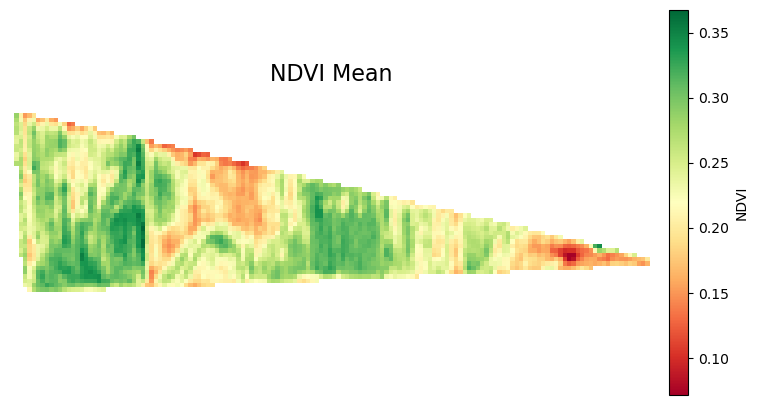

In [84]:
# Now I can calculate the mean NDVI index for the selected images
def calculate_ndvi(red_data, nir_data):
    """
    Calculates the Normalized Difference Vegetation Index (NDVI) from Red and NIR bands.

    NDVI is computed using the formula:
        NDVI = (NIR - RED) / (NIR + RED)

    Args:
        red_data (numpy.ndarray or float): Red band data.
        nir_data (numpy.ndarray or float): Near-Infrared (NIR) band data.

    Returns:
        numpy.ndarray or float: Calculated NDVI.
    """
    ndvi = (nir_data - red_data) / (nir_data + red_data)
    return ndvi

# Files of B04 (red) and B08 (nir)
red_band_files = [
    'T32TQQ_20220324T100649_B04_10m.jp2',
    'T32TQQ_20220428T100601_B04_10m.jp2',
    'T32TQQ_20220503T100549_B04_10m.jp2',
    'T32TQQ_20220612T100559_B04_10m.jp2',
    'T32TQQ_20220722T100559_B04_10m.jp2'
]

nir_band_files = [
    'T32TQQ_20220324T100649_B08_10m.jp2',
    'T32TQQ_20220428T100601_B08_10m.jp2',
    'T32TQQ_20220503T100549_B08_10m.jp2',
    'T32TQQ_20220612T100559_B08_10m.jp2',
    'T32TQQ_20220722T100559_B08_10m.jp2'
]

# Read and make an average calculation for each band
def read_and_average_bands(band_files):
    """
    Reads multiple raster band files and calculates the average band values.

    Args:
        band_files (list): List of file paths to raster band files.

    Returns:
        numpy.ndarray: Average band values across all input files.
        affine.Affine: Affine transformation information from the first band file.
        rasterio.crs.CRS: Coordinate reference system (CRS) from the first band file.
    """
    data_sum = None
    count = len(band_files)

    for band_file in band_files:
        with rasterio.open(band_file) as src:
            band_data = src.read(1).astype(float)
            if data_sum is None:
                data_sum = band_data
                transform = src.transform
                crs = src.crs
            else:
                data_sum += band_data

    data_avg = data_sum / count
    return data_avg, transform, crs

# Mean data (B04) and NIR (B08)
red_data, transform, crs = read_and_average_bands(red_band_files)
nir_data, _, _ = read_and_average_bands(nir_band_files)

# Mean NDVIl
ndvi_result = calculate_ndvi(red_data, nir_data)
ndvi_result = ndvi_result.astype(np.float32)

# Our polygon in gpkg
polygon_file = polygon_file
layer_name = 'Borders'

# Read the polygon
gdf = gpd.read_file(polygon_file, layer=layer_name)

# Check that polygon and raster have the same CRS
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# Extract geometries
geometries = gdf.geometry.values

# temp raster with NDVI
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=ndvi_result.shape[0],
        width=ndvi_result.shape[1],
        count=1,
        dtype=ndvi_result.dtype,
        crs=crs,
        transform=transform,
    ) as dataset:
        dataset.write(ndvi_result, 1)
        
        # Cut raster using our polygon
        out_image, out_transform = mask(dataset, geometries, crop=True, nodata=np.nan)
        out_meta = dataset.meta.copy()

# Update metadata of the cutted raster
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": np.nan
})

# Save the raster of interest
output_file = 'NDVI_mean.tif'
with rasterio.open(output_file, "w", **out_meta) as dest:
    dest.write(out_image)

# Plot the NDVI Mean
plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='RdYlGn')
cbar = plt.colorbar(label='NDVI', shrink=0.5, pad=0.02)
plt.title('NDVI Mean', fontsize=16, pad=20)
plt.gca().title.set_position([0.5, 1.05])  # Centra il titolo
plt.axis('off')
plt.show()


## Correlation Analysis

For the correlation analysis I needed to check the dimensions of the rasters. In my case the NDVI mean was a little bit shorter, so I applied a resampling on the data to correctly proceed with the correlation.

In [182]:
# Open the rasters
with rasterio.open('Resa_kg.tif') as yield_raster:
    yield_data = yield_raster.read(1)

with rasterio.open('NDVI_mean.tif') as ndvi_raster:
    ndvi_data = ndvi_raster.read(1)

with rasterio.open('Umidity.tif') as umidity_raster:
    umidity_data = umidity_raster.read(1)

    # Resample ndvi_data to match other data
    ndvi_resampled = np.empty(yield_data.shape, dtype=ndvi_data.dtype)
    reproject(
        ndvi_data, ndvi_resampled,
        src_transform=ndvi_raster.transform,
        src_crs=ndvi_raster.crs,
        dst_transform=yield_raster.transform,
        dst_crs=yield_raster.crs,
        resampling=Resampling.nearest)  # For resampling I selected a method that performs a nearest neighbor assignment

Now we can see that all the rasters have the same dimensions

In [183]:
umidity_data.shape

(59, 205)

In [106]:
ndvi_resampled.shape

(59, 205)

In [107]:
yield_data.shape

(59, 205)

I choose to utilize the Pearson correlation coefficient for the correlation. With values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation), it quantifies the linear relationship between two variables.

It is evident that the NDVI and Yield have a good association. Since the NDVI measures the health and density of the vegetation, this positive correlation implies that higher crop yields are linked to denser and healthier vegetation (higher NDVI values).

Furthermore, we observe a slight correlation between humidity and NDVI. The weak correlation indicates that there is no significant relationship between the product's humidity and NDVI on its own.

In [214]:
# Flatten the arrays to compute Pearson correlation coefficient
yield_flat = yield_data.flatten()
ndvi_flat = ndvi_resampled.flatten()
umidity_flat = umidity_data.flatten()

yield_mask = ~np.isnan(yield_flat) & ~np.isnan(ndvi_flat) # The mask is for handling the nan values of the matrix
umidity_mask = ~np.isnan(umidity_flat) & ~np.isnan(ndvi_flat)
corr_coeff_yeald_NDVI = np.corrcoef(yield_flat[yield_mask], ndvi_flat[yield_mask])[0, 1]
corr_coeff_umidity_NDVI = np.corrcoef(umidity_flat[umidity_mask], ndvi_flat[umidity_mask])[0, 1]

print(f"Pearson correlation coefficient Yield-NDVI: {corr_coeff_yeald_NDVI.round(2)}")
print(f"Pearson correlation coefficient Umidity-NDVI: {corr_coeff_umidity_NDVI.round(2)}")


Pearson correlation coefficient Yield-NDVI: 0.59
Pearson correlation coefficient Umidity-NDVI: 0.18


### Visualization: Scatterplot with Linear Regression

In [202]:
# Filtering data on the mask
yield_valid = yield_flat[yield_mask]
ndvi_yield = ndvi_flat[yield_mask]

umidity_valid = umidity_flat[umidity_mask]
ndvi_umidity = ndvi_flat[umidity_mask]

# Calculation of the correlation coefficient with numpy
correlation_coefficient_yield = np.corrcoef(yield_valid, ndvi_yield)[0, 1]
correlation_coefficient_umidity = np.corrcoef(umidity_valid, ndvi_umidity)[0, 1]

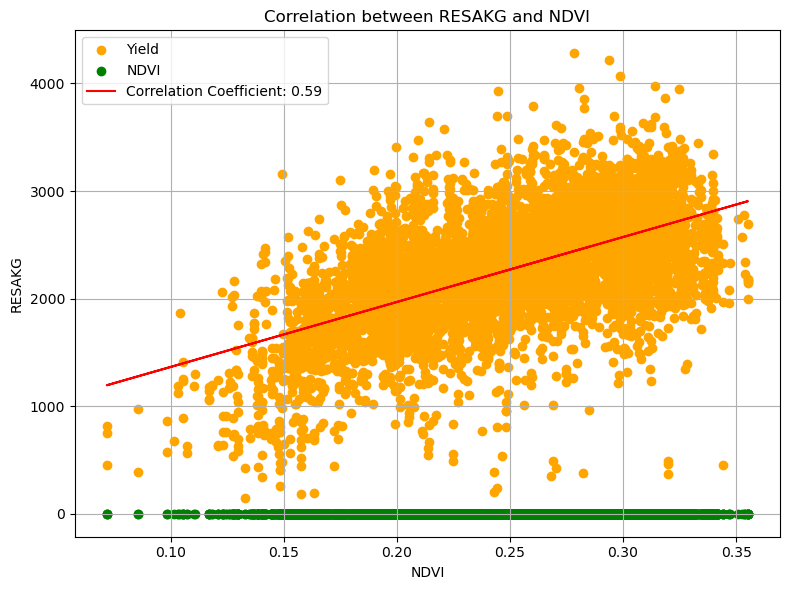

In [206]:
# Scatterplot creation for Yield and NDVI with Linear Regression
plt.figure(figsize=(8, 6))

# Yield
plt.scatter(ndvi_yield, yield_valid, color='orange', label='Yield')

# NDVI
plt.scatter(ndvi_yield, ndvi_yield, color='green', label='NDVI')

plt.title('Correlation between RESAKG and NDVI')
plt.xlabel('NDVI')
plt.ylabel('RESAKG')
plt.grid(True)

# The line for regression
m, b = np.polyfit(ndvi_yield, yield_valid, 1)
plt.plot(ndvi_yield, m * ndvi_yield + b, color='red', label=f'Correlation Coefficient: {correlation_coefficient_yield:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

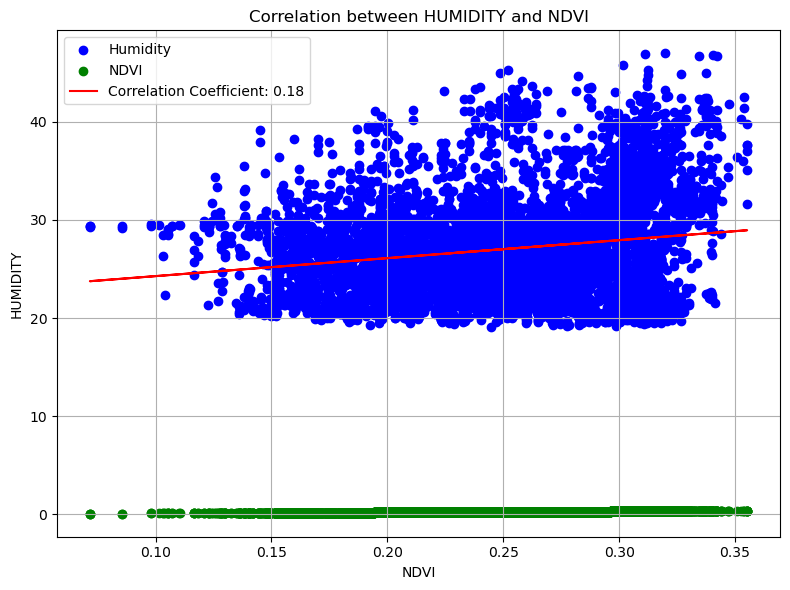

In [213]:
# Scatterplot creation for Humidity and NDVI with Linear Regression
plt.figure(figsize=(8, 6))

# Humidity
plt.scatter(ndvi_umidity, umidity_valid, color='blue', label='Humidity')

# NDVI
plt.scatter(ndvi_umidity, ndvi_umidity, color='green', label='NDVI')

plt.title('Correlation between HUMIDITY and NDVI')
plt.xlabel('NDVI')
plt.ylabel('HUMIDITY')
plt.grid(True)

# Line regression
m, b = np.polyfit(ndvi_umidity, umidity_valid, 1)
plt.plot(ndvi_umidity, m * ndvi_umidity + b, color='red', label=f'Correlation Coefficient: {correlation_coefficient_umidity:.2f}')

plt.legend()
plt.tight_layout()
plt.show()